- 阿里云供应链大赛比赛链接 https://tianchi.aliyun.com/competition/entrance/531934/information  
- 记录笔记 https://joyspace.jd.com/page/oWnUboNNUcrK43d99RG1  
- Code https://coding.jd.com/zhunian1/supply_demand_forecast/

- ref:   
1.https://github.com/mlpotter/Transformer_Time_Series  
2.https://zhuanlan.zhihu.com/p/391337035  

In [1]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
import os
import platform
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import xgboost as xgb
from xgboost import plot_importance
import pickle

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',100)

In [2]:
demand_train_A = pd.read_csv('../dataset/demand_train_A.csv')
demand_test_A = pd.read_csv('../dataset/demand_test_A.csv')
geo_topo = pd.read_csv('../dataset/geo_topo.csv')
inventory_info_A = pd.read_csv('../dataset/inventory_info_A.csv')
product_topo = pd.read_csv('../dataset/product_topo.csv')
weight_A = pd.read_csv('../dataset/weight_A.csv')

# 1. 特征工程
- 1.1 日期处理（天数补齐）
- 1.2 处理geography_level、product_level多级别特征
- 1.3 使用qty滑窗添加新特征：last14max、last14min、last14std、last14mean、last14median
- 1.4 过去14天下，在同geography与product的qty 资源使用量。

## 1.1 日期处理 （天数补齐）

In [3]:
first_dt = pd.to_datetime("20180604")  
last_dt = pd.to_datetime("20210301")  # 用来限定使用的是历史数据而不是未来数据
start_dt = pd.to_datetime("20210301")  # 用来划定预测的针对test的起始时间
end_dt = pd.to_datetime("20210607")  # 预测需求的截止时间

demand_train_A["ts"] = demand_train_A["ts"].apply(lambda x: pd.to_datetime(x))
demand_train_A.drop(['Unnamed: 0'],axis=1,inplace=True)

demand_test_A["ts"] = demand_test_A["ts"].apply(lambda x: pd.to_datetime(x))
demand_test_A.drop(['Unnamed: 0'],axis=1,inplace=True)

dataset = pd.concat([demand_train_A, demand_test_A])

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346768 entries, 0 to 61935
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unit             346768 non-null  object        
 1   ts               346768 non-null  datetime64[ns]
 2   qty              346768 non-null  float64       
 3   geography_level  346768 non-null  object        
 4   geography        346768 non-null  object        
 5   product_level    346768 non-null  object        
 6   product          346768 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 21.2+ MB


In [5]:
# 删除掉出现 qty中出现负值的样本，这部分样本数值不对
dataset = dataset[~(dataset.qty < 0)]
print(np.isnan(dataset['qty']).any())
print(np.isinf(dataset['qty']).any())

False
False


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345316 entries, 0 to 61935
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   unit             345316 non-null  object        
 1   ts               345316 non-null  datetime64[ns]
 2   qty              345316 non-null  float64       
 3   geography_level  345316 non-null  object        
 4   geography        345316 non-null  object        
 5   product_level    345316 non-null  object        
 6   product          345316 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 21.1+ MB


In [7]:
# unit count
dataset.unit.value_counts()

9b8f48bacb1a63612f3a210ccc6286cc    1100
6ed4341ad9d2902873f3d9272f5f4df1    1100
4d3ca213b639541c5ba4cf8a69b1e1ed    1100
06531cd4188630ce2497cd9983aacf5e    1100
326cb18b045e5baefa90bbc2e8d52a32    1100
                                    ... 
7d9cbb373fddba4ce2cddcec96bccbeb     148
8ccf1c02bb050cb3fc4f13789cdfe235     147
e9abc1de6bd24d10ebe608959d0e5bac     141
5dbe225a546a680640eb5f7902b42cdd     141
12f892a6de3f9cf4411fb9db4fdd6691     138
Name: unit, Length: 632, dtype: int64

In [40]:
np.sort(dataset.qty.values)

array([     0.        ,      0.        ,      0.        , ...,
       189543.66666667, 189548.66666667, 189610.33333333])

In [41]:
all_date = (dataset.ts.max()-dataset.ts.min()).days + 1
print("样本统计的天数：", all_date)  # Unit 的 天数

# 所有Unit都补全 all_date天的数据
cols = dataset.columns
trainalldate = pd.DataFrame()

for unit in dataset.unit.drop_duplicates():
    tmppd = pd.DataFrame(index=pd.date_range(first_dt, periods=all_date))
    tmppd['unit'] = unit
    tmppd = tmppd.reset_index()
    tmppd.columns = ['ts','unit']
    tmppd = pd.merge(left = tmppd,right = dataset[dataset.unit == unit],how = 'left',on = ['ts','unit']
        )
    #tmppd.fillna(value={'qty':-1},inplace=True)
    #tmppd.fillna(value={'qty':-1},method='bfill',inplace=True)
    trainalldate = pd.concat([trainalldate, tmppd])


样本统计的天数： 1100


In [42]:
# unit count
trainalldate.unit.value_counts()

9b8f48bacb1a63612f3a210ccc6286cc    1100
fbb83aefc6f5d6f6bc22ae3ee757d327    1100
c667afe1760f1e611bbf1429a4d324c4    1100
159cb1b7310e185dedda75e02d75344c    1100
c33ea1a813aed8ea5c19733d0729843d    1100
                                    ... 
380ad6e9d053693ab13f4da6940169ee    1100
d265d3620336f88bb6b49ac2e38c60ae    1100
e0bb0f05aa6823bddee312429820c1dc    1100
9a27f2c80de3ad06d7b57f5ec302c19e    1100
12f892a6de3f9cf4411fb9db4fdd6691    1100
Name: unit, Length: 632, dtype: int64

<AxesSubplot:xlabel='ts', ylabel='qty'>

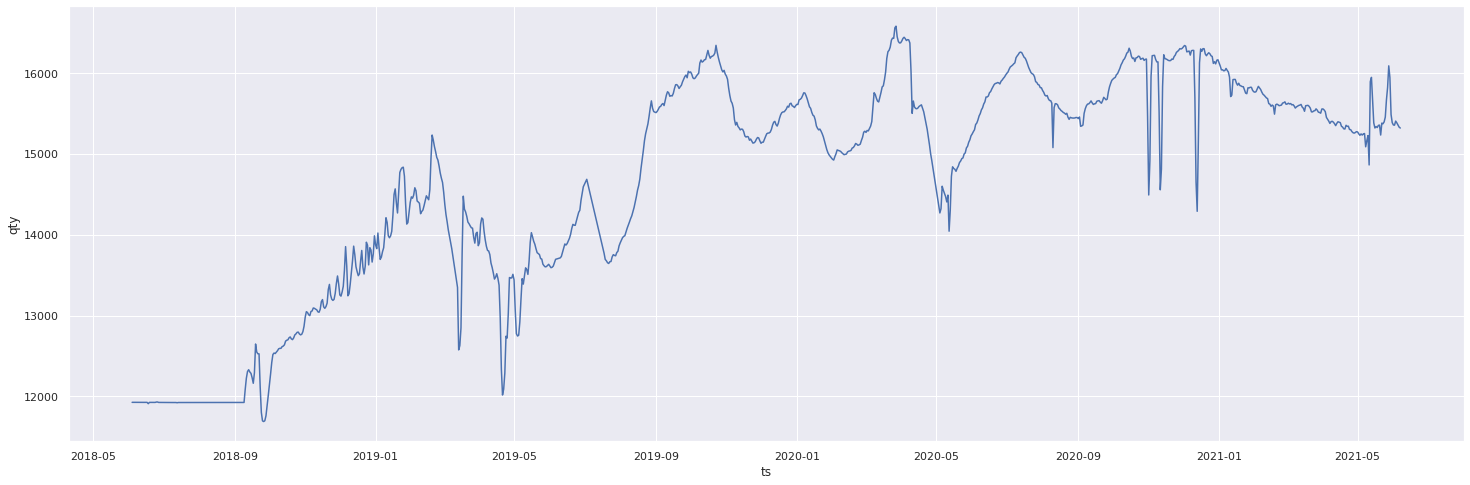

In [ ]:
# 不完整的数据
sns.set(rc={'figure.figsize':(25,8)})
sns.lineplot(y =trainalldate[trainalldate.unit == '9b8f48bacb1a63612f3a210ccc6286cc'].qty,
             x =trainalldate[trainalldate.unit == '9b8f48bacb1a63612f3a210ccc6286cc'].ts)

<AxesSubplot:xlabel='ts', ylabel='qty'>

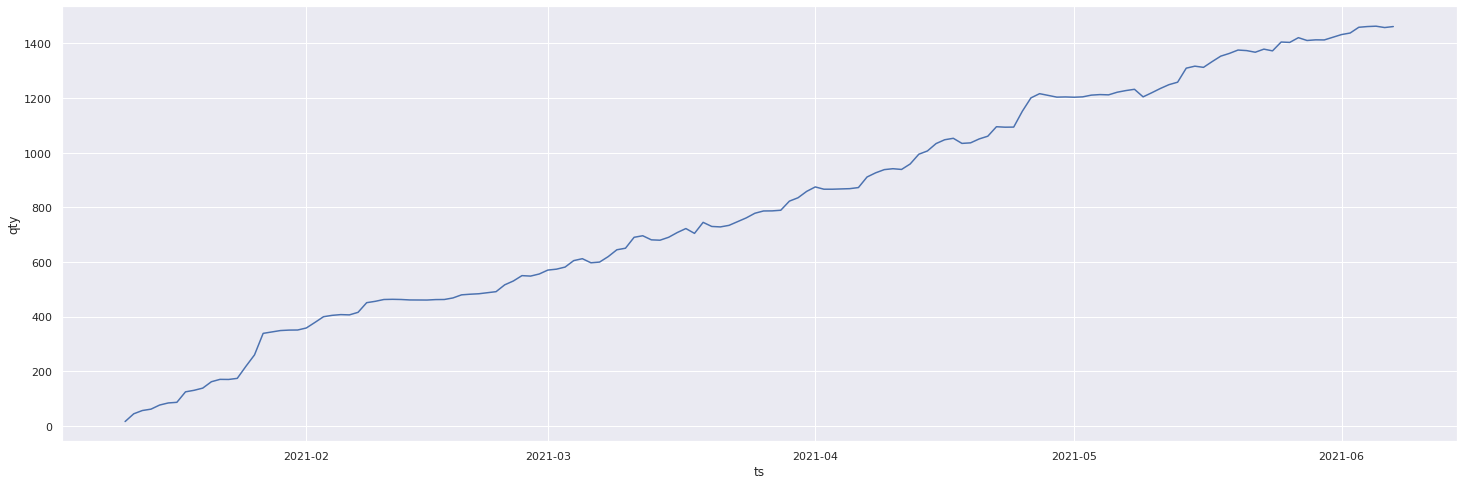

In [44]:
# 不完整的数据
sns.set(rc={'figure.figsize':(25,8)})
sns.lineplot(y =trainalldate[trainalldate.unit == '7d9cbb373fddba4ce2cddcec96bccbeb'].qty,
             x =trainalldate[trainalldate.unit == '7d9cbb373fddba4ce2cddcec96bccbeb'].ts)

In [45]:
trainalldate[trainalldate.unit == '7d9cbb373fddba4ce2cddcec96bccbeb']

,ts,unit,qty,geography_level,geography,product_level,product
0,2018-06-04,7d9cbb373fddba4ce2cddcec96bccbeb,NaN,NaN,NaN,NaN,NaN
1,2018-06-05,7d9cbb373fddba4ce2cddcec96bccbeb,NaN,NaN,NaN,NaN,NaN
2,2018-06-06,7d9cbb373fddba4ce2cddcec96bccbeb,NaN,NaN,NaN,NaN,NaN
3,2018-06-07,7d9cbb373fddba4ce2cddcec96bccbeb,NaN,NaN,NaN,NaN,NaN
4,2018-06-08,7d9cbb373fddba4ce2cddcec96bccbeb,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1095,2021-06-03,7d9cbb373fddba4ce2cddcec96bccbeb,1459.333333,geography_level_3,ec258532d911270434f328606cba61b6,product_level_2,45fe7a01980958e559fa0473c20c8c58
1096,2021-06-04,7d9cbb373fddba4ce2cddcec96bccbeb,1462.000000,geography_level_3,ec258532d911270434f328606cba61b6,product_level_2,45fe7a01980958e559fa0473c20c8c58
1097,2021-06-05,7d9cbb373fddba4ce2cddcec96bccbeb,1463.333333,geography_level_3,ec258532d911270434f328606cba61b6,product_level_2,45fe7a01980958e559fa0473c20c8c58
1098,2021-06-06,7d9cbb373fddba4ce2cddcec96bccbeb,1458.333333,geography_level_3,ec258532d911270434f328606cba61b6,product_level_2,45fe7a01980958e559fa0473c20c8c58


针对这个 unit:7d9cbb373fddba4ce2cddcec96bccbeb 单元，补齐所有的时间NaN，绘图中空值没有体现出来。

In [47]:
# 添加 year, month, day 日期特征
trainalldate['year'] = trainalldate['ts'].dt.year
trainalldate['month'] = trainalldate['ts'].dt.month
trainalldate['day'] = trainalldate['ts'].dt.day
trainalldate['week'] = trainalldate['ts'].dt.weekday
trainalldate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ts               695200 non-null  datetime64[ns]
 1   unit             695200 non-null  object        
 2   qty              345316 non-null  float64       
 3   geography_level  345316 non-null  object        
 4   geography        345316 non-null  object        
 5   product_level    345316 non-null  object        
 6   product          345316 non-null  object        
 7   year             695200 non-null  int64         
 8   month            695200 non-null  int64         
 9   day              695200 non-null  int64         
 10  week             695200 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 63.6+ MB


## 1.2 处理geography_level、product_level多级别特征

In [48]:
trainalldate = trainalldate.drop(['geography_level','product_level'],axis = 1)
trainalldate = pd.merge(trainalldate, geo_topo, how='left', left_on = 'geography', right_on = 'geography_level_3')
trainalldate = pd.merge(trainalldate, product_topo, how='left', left_on = 'product', right_on = 'product_level_2')
trainalldate = trainalldate.drop(['geography','product'],axis = 1)
trainalldate.head()

,ts,unit,qty,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2
0,2018-06-04,9b8f48bacb1a63612f3a210ccc6286cc,11926.8286,2018,6,4,0,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
1,2018-06-05,9b8f48bacb1a63612f3a210ccc6286cc,11927.2286,2018,6,5,1,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
2,2018-06-06,9b8f48bacb1a63612f3a210ccc6286cc,11926.8286,2018,6,6,2,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
3,2018-06-07,9b8f48bacb1a63612f3a210ccc6286cc,11926.6286,2018,6,7,3,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c
4,2018-06-08,9b8f48bacb1a63612f3a210ccc6286cc,11926.4286,2018,6,8,4,c89adbf4129750cd35f3b818167cd7ab,7a399889b9a4aed64afd0cf95941b975,36ab7b000da26b0547bfc3c3fdf143dc,3696441120a402f793a704766540e69e,5cc8015f03554313900f069182bdaf9c


In [49]:
# labelEncoder
encoder = ['geography_level_1','geography_level_2','geography_level_3','product_level_1','product_level_2']
# add feature
# unit_all = ['unit_geo', 'unit_pro', 'geo_pro']
unit_all = [ 'unit_pro', 'geo_pro']

# trainalldate["unit_geo"] = trainalldate.apply(lambda x: f"{x['unit']}_{x['geography_level_3']}", axis=1)
trainalldate["unit_pro"] = trainalldate.apply(lambda x: f"{x['unit']}_{x['product_level_2']}", axis=1)
trainalldate["geo_pro"] = trainalldate.apply(lambda x: f"{x['geography_level_3']}_{x['product_level_2']}", axis=1)

lbl = LabelEncoder()
for feat in encoder+unit_all:
    lbl.fit(trainalldate[feat])
    trainalldate[feat] = lbl.transform(trainalldate[feat])


In [50]:
# add the weight of each units
trainalldate = pd.merge(trainalldate, weight_A, left_on = 'unit', right_on = 'unit')
trainalldate = trainalldate.drop(['Unnamed: 0'],axis = 1)

In [ ]:
# unit to unit_id
enc_unit = lbl.fit(trainalldate['unit'])
trainalldate['unit'] = enc_unit.transform(trainalldate['unit'])
trainalldate.head()

# unit id -> 反编码
# enc_unit.inverse_transform(trainalldate['unit'])

,ts,unit,qty,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,unit_pro,geo_pro,weight
0,2018-06-04,386,11926.8286,2018,6,4,0,5,12,11,1,6,761,85,0.079
1,2018-06-05,386,11927.2286,2018,6,5,1,5,12,11,1,6,761,85,0.079
2,2018-06-06,386,11926.8286,2018,6,6,2,5,12,11,1,6,761,85,0.079
3,2018-06-07,386,11926.6286,2018,6,7,3,5,12,11,1,6,761,85,0.079
4,2018-06-08,386,11926.4286,2018,6,8,4,5,12,11,1,6,761,85,0.079


In [53]:
# save to pkl
# trainalldate.to_csv('../output/trainalldate.csv', index=False)
import pickle

with open("../output/trainalldate.pkl", 'wb') as fo: 
    pickle.dump(trainalldate, fo)

## 1.3 使用qty滑窗添加新特征：last14max、last14min、last14std、last14mean、last14median、last14sum
Ref: https://zhuanlan.zhihu.com/p/101284491

In [54]:
with open("../output/trainalldate.pkl", 'rb') as fo:     # 读取pkl文件数据
    trainalldate = pickle.load(fo, encoding='bytes')

trainalldate["ts"] = trainalldate["ts"].apply(lambda x: pd.to_datetime(x))
print(trainalldate.shape)
trainalldate.head()

(695200, 15)


,ts,unit,qty,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,unit_pro,geo_pro,weight
0,2018-06-04,386,11926.8286,2018,6,4,0,5,12,11,1,6,761,85,0.079
1,2018-06-05,386,11927.2286,2018,6,5,1,5,12,11,1,6,761,85,0.079
2,2018-06-06,386,11926.8286,2018,6,6,2,5,12,11,1,6,761,85,0.079
3,2018-06-07,386,11926.6286,2018,6,7,3,5,12,11,1,6,761,85,0.079
4,2018-06-08,386,11926.4286,2018,6,8,4,5,12,11,1,6,761,85,0.079


In [55]:
trainalldate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int64         
 2   qty                345316 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   week               695200 non-null  int64         
 7   geography_level_1  695200 non-null  int64         
 8   geography_level_2  695200 non-null  int64         
 9   geography_level_3  695200 non-null  int64         
 10  product_level_1    695200 non-null  int64         
 11  product_level_2    695200 non-null  int64         
 12  unit_pro           695200 non-null  int64         
 13  geo_pro            695200 non-null  int64   

In [84]:
def qtyGetKvalue(data, k):
    '''
    k: the last k-ist value of data
    '''
    data = data.sort_values(
        by=['ts'], ascending=True).reset_index(drop=True)
    data = data.iloc[len(data) - k, -1] if len(data) >= k else np.NaN
    return data

def qtyNewFeature(df, ts = np.nan):
    newdataset = pd.DataFrame()
    
    timeline = pd.date_range(df.ts.min(), df.ts.max())
    for t in timeline:
        
        # today
        ts = df[df.ts == t]
        
        # last 14 day information ... 
        rdd = df[(df.ts >= t - datetime.timedelta(14)) & (df.ts < t)]
        
        last14max_dict = rdd.groupby('unit')['qty'].max().to_dict()
        last14min_dict = rdd.groupby('unit')['qty'].min().to_dict()
        last14std_dict = rdd.groupby('unit')['qty'].std().to_dict()
        last14mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last14median_dict = rdd.groupby('unit')['qty'].median().to_dict()
        last14sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        
        ts['last14max'] = ts['unit'].map(last14max_dict)
        ts['last14min'] = ts['unit'].map(last14min_dict)
        ts['last14std'] = ts['unit'].map(last14std_dict)
        ts['last14mean'] = ts['unit'].map(last14mean_dict)
        ts['last14median'] = ts['unit'].map(last14median_dict)
        ts['last14sum'] = ts['unit'].map(last14sum_dict)
        
        
        # last 7 day information ..
        rdd = df[(df.ts >= t - datetime.timedelta(7)) & (df.ts < t)]
        
        last7max_dict = rdd.groupby('unit')['qty'].max().to_dict()
        last7min_dict = rdd.groupby('unit')['qty'].min().to_dict()
        last7std_dict = rdd.groupby('unit')['qty'].std().to_dict()
        last7mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last7median_dict = rdd.groupby('unit')['qty'].median().to_dict()
        last7sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        
        ts['last7max'] = ts['unit'].map(last7max_dict)
        ts['last7min'] = ts['unit'].map(last7min_dict)
        ts['last7std'] = ts['unit'].map(last7std_dict)
        ts['last7mean'] = ts['unit'].map(last7mean_dict)
        ts['last7median'] = ts['unit'].map(last7median_dict)
        ts['last7sum'] = ts['unit'].map(last7sum_dict)
        
        
        # last 3 day information ...
        rdd = df[(df.ts >= t - datetime.timedelta(3)) & (df.ts < t)]
        
        last3max_dict = rdd.groupby('unit')['qty'].max().to_dict()
        last3min_dict = rdd.groupby('unit')['qty'].min().to_dict()
        last3std_dict = rdd.groupby('unit')['qty'].std().to_dict()
        last3mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last3median_dict = rdd.groupby('unit')['qty'].median().to_dict()
        last3sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        last3value_dict = rdd.groupby('unit')['ts', 'qty'].apply(qtyGetKvalue, k=3).to_dict()
        
        ts['last3max'] = ts['unit'].map(last3max_dict)
        ts['last3min'] = ts['unit'].map(last3min_dict)
        ts['last3std'] = ts['unit'].map(last3std_dict)
        ts['last3mean'] = ts['unit'].map(last3mean_dict)
        ts['last3median'] = ts['unit'].map(last3median_dict)
        ts['last3sum'] = ts['unit'].map(last3sum_dict)
        ts['last3value'] = ts['unit'].map(last3value_dict)
        
        
        # last 1、2 day information ..
        rdd = df[(df.ts >= t - datetime.timedelta(1)) & (df.ts < t)]
        last1value_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        ts['last1value'] = ts['unit'].map(last1value_dict)
        
        rdd = df[(df.ts >= t - datetime.timedelta(2)) & (df.ts < t)]
        last2mean_dict = rdd.groupby('unit')['qty'].mean().to_dict()
        last2sum_dict = rdd.groupby('unit')['qty'].sum().to_dict()
        last2value_dict = rdd.groupby('unit')['ts', 'qty'].apply(qtyGetKvalue, k=2).to_dict()
        
        ts['last2mean'] = ts['unit'].map(last2mean_dict)
        ts['last2sum'] = ts['unit'].map(last2sum_dict)
        ts['last2value'] = ts['unit'].map(last2value_dict)
        
        newdataset = pd.concat([newdataset, ts])
        if t.month == 1 and t.day == 1:
            print(t)
    return newdataset

# # 适合样本量比较少的训练集
# def qtyNewFeaturelow(df, ts = np.nan):
#     df['last14max'] = np.nan
#     df['last14min'] = np.nan
#     df['last14std'] = np.nan
#     df['last14mean'] = np.nan
#     df['last14median'] = np.nan
#     df['last14sum'] = np.nan
    
#     for i in range(df.shape[0]):
#         currset = df.iloc[i:i+1,:]
        
#         unit = currset['unit'].values[0]
#         ts = pd.to_datetime(currset['ts'].values[0])
#         last14set = df[(df.unit == unit) & (df.ts >= ts - datetime.timedelta(14)) & (df.ts < ts)]

#         df.loc[currset.index,'last14max'] = np.max(last14set['qty'])
#         df.loc[currset.index,'last14min'] = np.min(last14set['qty'])
#         df.loc[currset.index,'last14std'] = np.std(last14set['qty'])
#         df.loc[currset.index,'last14mean'] = np.mean(last14set['qty'])
#         df.loc[currset.index,'last14median'] = np.median(last14set['qty'])
#         df.loc[currset.index,'last14sum'] = np.sum(last14set['qty'])
#         # print(currset.index)
#     return df

In [86]:
traindataset = qtyNewFeature(trainalldate)

2019-01-01 00:00:00
2020-01-01 00:00:00
2021-01-01 00:00:00


In [87]:
traindataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 38 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int64         
 2   qty                345316 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   week               695200 non-null  int64         
 7   geography_level_1  695200 non-null  int64         
 8   geography_level_2  695200 non-null  int64         
 9   geography_level_3  695200 non-null  int64         
 10  product_level_1    695200 non-null  int64         
 11  product_level_2    695200 non-null  int64         
 12  unit_pro           695200 non-null  int64         
 13  geo_pro            695200 non-null  int64   

In [7]:
traindataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int64         
 2   qty                346768 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   week               695200 non-null  int64         
 7   geography_level_1  695200 non-null  int64         
 8   geography_level_2  695200 non-null  int64         
 9   geography_level_3  695200 non-null  int64         
 10  product_level_1    695200 non-null  int64         
 11  product_level_2    695200 non-null  int64         
 12  unit_pro           695200 non-null  int64         
 13  geo_pro            695200 non-null  int64   

In [33]:
# train1q = qtyNewFeaturelow(trainalldate[:1000])
# train1q.head()

,ts,unit,qty,year,month,day,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,unit_geo_pro,weight,last14max,last14min,last14std,last14mean,last14median,last14sum
0,2018-06-04,386,11926.8286,2018,6,4,5,12,11,1,6,761,0.079,NaN,NaN,NaN,NaN,NaN,0.0000
1,2018-06-05,386,11927.2286,2018,6,5,5,12,11,1,6,761,0.079,11926.8286,11926.8286,0.000000,11926.828600,11926.8286,11926.8286
2,2018-06-06,386,11926.8286,2018,6,6,5,12,11,1,6,761,0.079,11927.2286,11926.8286,0.200000,11927.028600,11927.0286,23854.0572
3,2018-06-07,386,11926.6286,2018,6,7,5,12,11,1,6,761,0.079,11927.2286,11926.8286,0.188562,11926.961933,11926.8286,35780.8858
4,2018-06-08,386,11926.4286,2018,6,8,5,12,11,1,6,761,0.079,11927.2286,11926.6286,0.217945,11926.878600,11926.8286,47707.5144


In [ ]:
## PRINT...

# today
t = pd.to_datetime("20180606")
# ts = trainalldate[trainalldate.ts == pd.to_datetime("20210601")]
rdd = trainalldate[(trainalldate.ts >= t - datetime.timedelta(2)) & (trainalldate.ts < t)]

# # last 14 day information ... 
# rdd = df[(df.ts >= t - datetime.timedelta(14)) & (df.ts < t)]
rdd.groupby('unit')['ts', 'qty'].apply(qtyGetKvalue, k=3)

## 1.4 过去14天下，在同geography与product的qty 资源使用量。

In [89]:
def geoproNewFeature(df):
    newdataset = pd.DataFrame()
    
    timeline = pd.date_range(df.ts.min(), df.ts.max())
    for t in timeline:
        ts = df[df.ts == t]
        rdd = df[(df.ts >= t - datetime.timedelta(14)) & (df.ts < t)]
        
        # grouby for calculate mean&median
        geo1mean14_dict = rdd.groupby('geography_level_1')['qty'].mean().to_dict()
        geo2mean14_dict = rdd.groupby('geography_level_2')['qty'].mean().to_dict()
        geo3mean14_dict = rdd.groupby('geography_level_3')['qty'].mean().to_dict()
        pro1mean14_dict = rdd.groupby('product_level_1')['qty'].mean().to_dict()
        pro2mean14_dict = rdd.groupby('product_level_2')['qty'].mean().to_dict()
        geo1median14_dict = rdd.groupby('geography_level_1')['qty'].median().to_dict()
        geo2median14_dict = rdd.groupby('geography_level_2')['qty'].median().to_dict()
        geo3median14_dict = rdd.groupby('geography_level_3')['qty'].median().to_dict()
        pro1median14_dict = rdd.groupby('product_level_1')['qty'].median().to_dict()
        pro2median14_dict = rdd.groupby('product_level_2')['qty'].median().to_dict()
        
        # map to df
        ts['geo1mean14'] = ts['geography_level_1'].map(geo1mean14_dict)
        ts['geo2mean14'] = ts['geography_level_2'].map(geo2mean14_dict)
        ts['geo3mean14'] = ts['geography_level_3'].map(geo3mean14_dict)
        ts['pro1mean14'] = ts['product_level_1'].map(pro1mean14_dict)
        ts['pro2mean14'] = ts['product_level_2'].map(pro2mean14_dict)
        
        ts['geo1median14'] = ts['geography_level_1'].map(geo1median14_dict)
        ts['geo2median14'] = ts['geography_level_2'].map(geo2median14_dict)
        ts['geo3median14'] = ts['geography_level_3'].map(geo3median14_dict)
        ts['pro1median14'] = ts['product_level_1'].map(pro1median14_dict)
        ts['pro2median14'] = ts['product_level_2'].map(pro2median14_dict)
        

        
        
#         # grouby rdd for calculate mean&median and transform DataFrame
#         ts['geo1mean14'] = rdd.groupby('geography_level_1')['qty'].transform('mean')
#         ts['geo2mean14'] = rdd.groupby('geography_level_2')['qty'].transform('mean')
#         ts['geo3mean14'] = rdd.groupby('geography_level_3')['qty'].transform('mean')
#         ts['pro1mean14'] = rdd.groupby('product_level_1')['qty'].transform('mean')
#         ts['pro2mean14'] = rdd.groupby('product_level_2')['qty'].transform('mean')
#         ts['geo1median14'] = rdd.groupby('geography_level_1')['qty'].transform('median')
#         ts['geo2median14'] = rdd.groupby('geography_level_2')['qty'].transform('median')
#         ts['geo3median14'] = rdd.groupby('geography_level_3')['qty'].transform('median')
#         ts['pro1median14'] = rdd.groupby('product_level_1')['qty'].transform('median')
#         ts['pro2median14'] = rdd.groupby('product_level_2')['qty'].transform('median')
        
        newdataset = pd.concat([newdataset, ts])
        # print(t)
        if t.month == 1:
            print(t)
    return newdataset

In [90]:
traindatasetall = geoproNewFeature(traindataset)
traindatasetall

2019-01-01 00:00:00
2019-01-02 00:00:00
2019-01-03 00:00:00
2019-01-04 00:00:00
2019-01-05 00:00:00
2019-01-06 00:00:00
2019-01-07 00:00:00
2019-01-08 00:00:00
2019-01-09 00:00:00
2019-01-10 00:00:00
2019-01-11 00:00:00
2019-01-12 00:00:00
2019-01-13 00:00:00
2019-01-14 00:00:00
2019-01-15 00:00:00
2019-01-16 00:00:00
2019-01-17 00:00:00
2019-01-18 00:00:00
2019-01-19 00:00:00
2019-01-20 00:00:00
2019-01-21 00:00:00
2019-01-22 00:00:00
2019-01-23 00:00:00
2019-01-24 00:00:00
2019-01-25 00:00:00
2019-01-26 00:00:00
2019-01-27 00:00:00
2019-01-28 00:00:00
2019-01-29 00:00:00
2019-01-30 00:00:00
2019-01-31 00:00:00
2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-18 00:00:00
2020-01-19 00:00:00


,ts,unit,qty,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,...,geo1mean14,geo2mean14,geo3mean14,pro1mean14,pro2mean14,geo1median14,geo2median14,geo3median14,pro1median14,pro2median14
0,2018-06-04,386,11926.828600,2018,6,4,0,5,12,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,2018-06-04,463,6282.726600,2018,6,4,0,0,3,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2200,2018-06-04,273,285.329000,2018,6,4,0,0,10,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3300,2018-06-04,520,6672.645200,2018,6,4,0,1,11,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4400,2018-06-04,480,15204.590200,2018,6,4,0,7,4,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690799,2021-06-07,302,1462.000000,2021,6,7,0,0,3,75,...,10141.205512,13880.438325,16207.999937,8067.832205,3325.410256,2716.905924,5288.833333,5912.333333,1972.833333,931.166667
691899,2021-06-07,351,102.968750,2021,6,7,0,1,24,31,...,9295.733896,9752.352741,26.405971,2833.526550,2356.061415,2515.841471,2668.224772,1.364692,1167.225749,2791.153971
692999,2021-06-07,581,818.130654,2021,6,7,0,1,24,1,...,9295.733896,9752.352741,13110.153816,596.906691,310.037121,2515.841471,2668.224772,2931.634115,163.373630,87.582758
694099,2021-06-07,230,1955.625000,2021,6,7,0,1,24,1,...,9295.733896,9752.352741,13110.153816,596.906691,883.776261,2515.841471,2668.224772,2931.634115,163.373630,548.854167


In [91]:
# traindatasetall.to_csv("../output/traindatasetall.csv", index=False)
import pickle

with open("../output/traindataset.pkl", 'wb') as fo: 
    pickle.dump(traindatasetall, fo)

In [149]:
traindatasetall.to_csv("../output/traindatasetall.csv", index=False)

In [92]:
traindatasetall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 48 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int64         
 2   qty                345316 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   week               695200 non-null  int64         
 7   geography_level_1  695200 non-null  int64         
 8   geography_level_2  695200 non-null  int64         
 9   geography_level_3  695200 non-null  int64         
 10  product_level_1    695200 non-null  int64         
 11  product_level_2    695200 non-null  int64         
 12  unit_pro           695200 non-null  int64         
 13  geo_pro            695200 non-null  int64   

In [ ]:
currset = trainalldate.iloc[50:51,:]
unit = currset['unit'].values[0]
ts = pd.to_datetime(currset['ts'].values[0])

In [ ]:
trainalldate[(trainalldate.ts >= ts - datetime.timedelta(14)) & (trainalldate.ts < ts)].ts.value_counts()

In [ ]:
currset

In [ ]:
rdd = trainalldate[(trainalldate.ts >= ts - datetime.timedelta(14)) & (trainalldate.ts < ts)]
rdd.groupby('geography_level_1')['qty'].mean().to_dict()

In [ ]:
dict_ = rdd.groupby('geography_level_1')['qty'].mean().to_dict()

In [ ]:
rdd.groupby('geography_level_2')['qty'].mean().to_dict()

# 2. 数据分析
- 2.1 日期与库存销量qty之间的关系
- 2.2 weight 特征与其他指标之间的分析
- 2.3 geography和product与库存销量qty之间的关系

## 2.1 日期与库存销量qty之间的关系
- 1.哪月库存销量最佳, 随着日期变化，库存均销量的变化趋势是怎么样的?
- 2.一个月中哪个天的库存销量是最好的？

In [139]:
# 统计2020-1-1 至 2021-1-1 日之间销量情况
l = pd.to_datetime("20200101")  
r = pd.to_datetime("20210101")
rdd = trainalldate[(trainalldate.ts >= l) & (trainalldate.ts < r)]

In [140]:
print(len(rdd.ts.unique()),  len(rdd.unit.unique()))  # the day and all the unit

366 632


month
1     7192.430061
2     7314.206949
3     7604.787311
4     7816.873783
5     7654.873306
6     7414.775432
7     7338.711291
8     7143.824906
9     6443.558908
10    6322.372180
11    6342.427577
12    6338.860666
Name: qty, dtype: float64

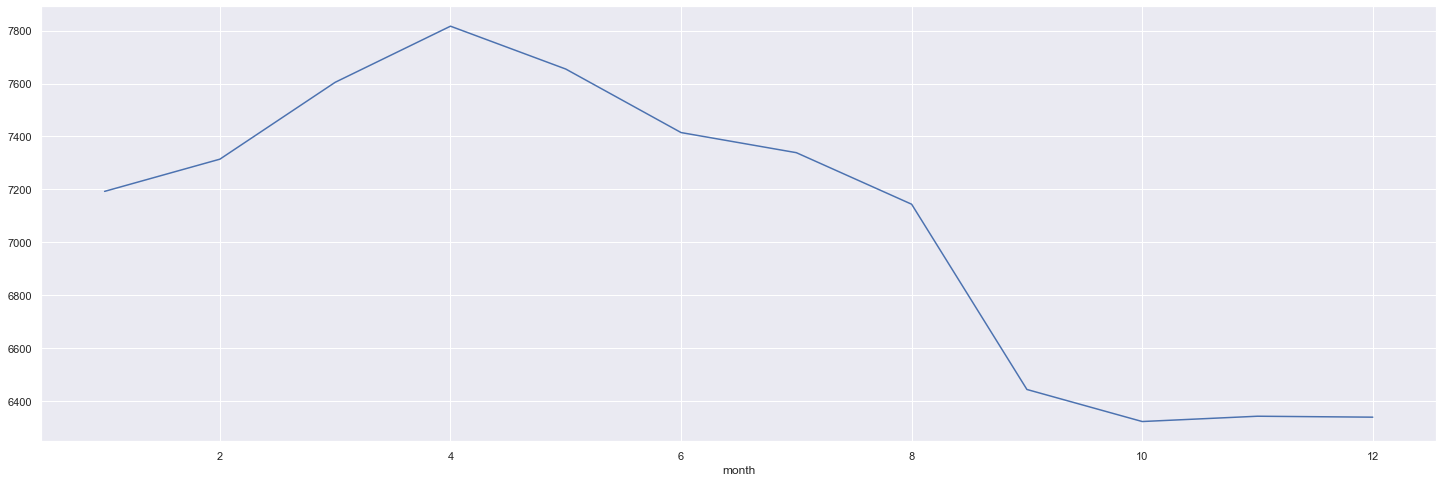

In [141]:
rdd.groupby('month')['qty'].mean().plot.line()
rdd.groupby('month')['qty'].mean()

week
0    6998.214075
1    6987.379158
2    6992.602257
3    6990.622916
4    7007.556214
5    7002.836863
6    6995.769412
Name: qty, dtype: float64

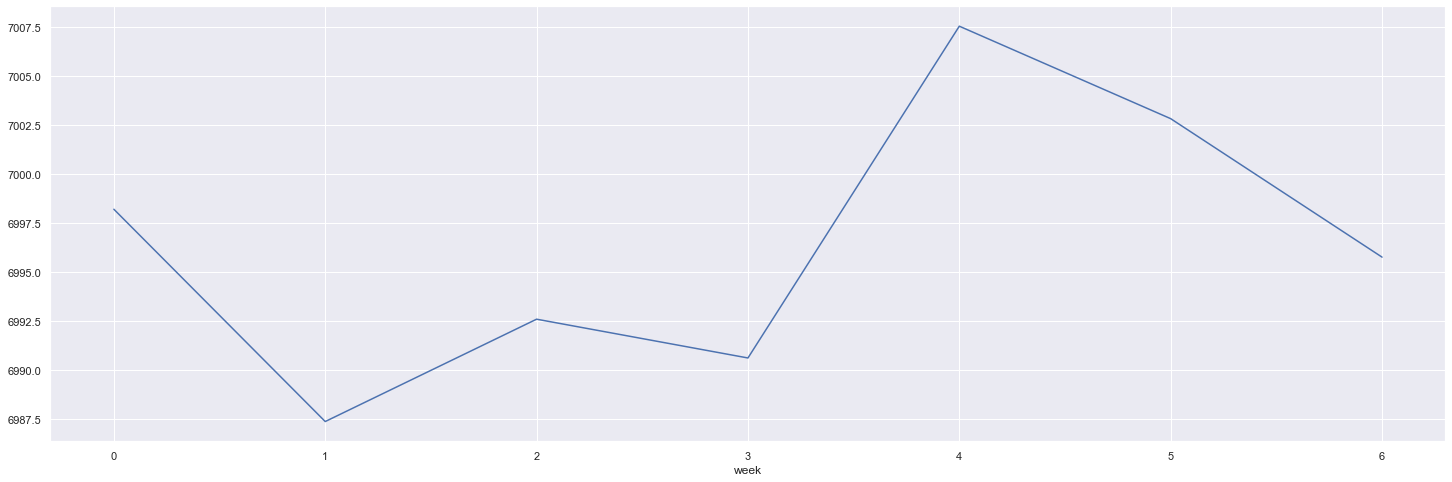

In [142]:
rdd.groupby('week')['qty'].mean().plot.line()
rdd.groupby('week')['qty'].mean()

day
1     6993.748347
2     6999.371259
3     7015.289851
4     7018.499768
5     7018.676319
6     7017.917442
7     7020.143570
8     7022.027495
9     7016.710293
10    7009.936242
11    6996.371593
12    6985.436419
13    6985.696083
14    6990.424792
15    6997.506983
16    6997.106383
17    6994.528477
18    6994.665844
19    6993.159391
20    6991.567334
21    6993.088720
22    6989.302981
23    6988.471516
24    6986.661363
25    6985.855417
26    6983.847853
27    6983.234482
28    6983.565259
29    6980.868594
30    6953.772138
31    7004.190051
Name: qty, dtype: float64

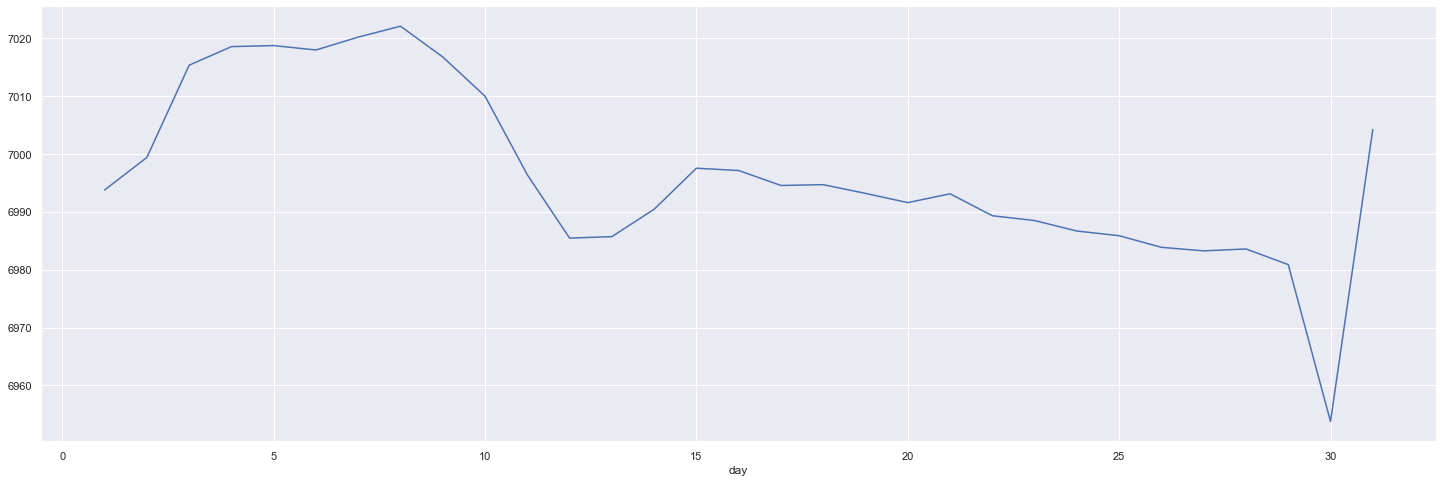

In [46]:
rdd.groupby('day')['qty'].mean().plot.line()
rdd.groupby('day')['qty'].mean()

In [126]:
# the high day is 8
# count the 8 of all year
daysYear = pd.Series(pd.date_range(start=l, end=r))
weeks = list(map(lambda x:x.day_name(), filter(lambda x:x.day == 8, daysYear)))
print(list(filter(lambda x:x.day == 8, daysYear)))
print(weeks)

[Timestamp('2020-01-08 00:00:00'), Timestamp('2020-02-08 00:00:00'), Timestamp('2020-03-08 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-07-08 00:00:00'), Timestamp('2020-08-08 00:00:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-10-08 00:00:00'), Timestamp('2020-11-08 00:00:00'), Timestamp('2020-12-08 00:00:00')]
['Wednesday', 'Saturday', 'Sunday', 'Wednesday', 'Friday', 'Monday', 'Wednesday', 'Saturday', 'Tuesday', 'Thursday', 'Sunday', 'Tuesday']


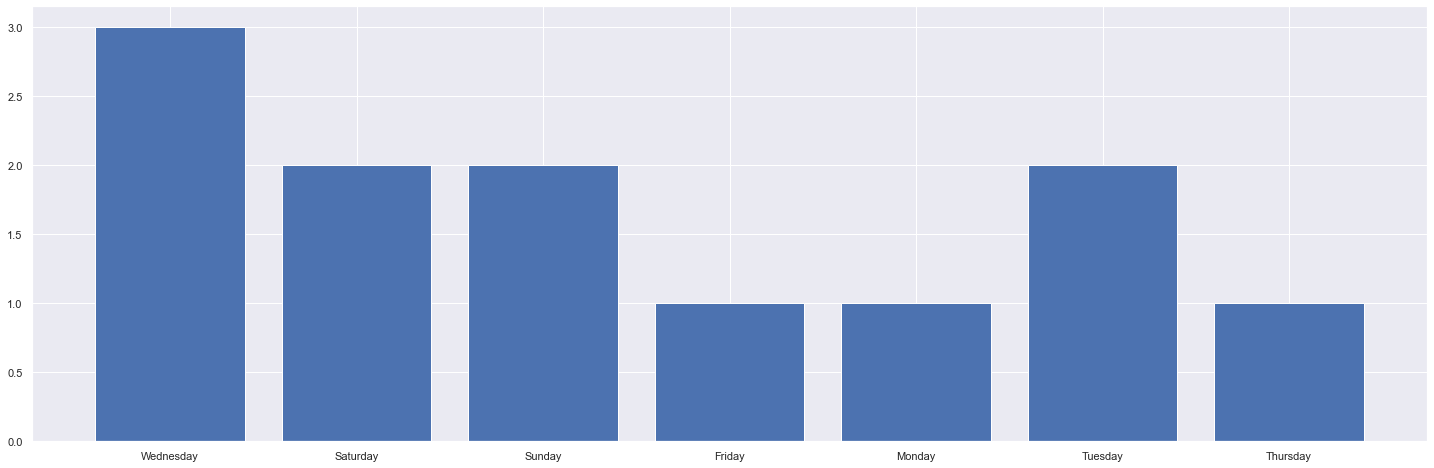

In [143]:
import collections
a = collections.Counter(weeks)
plt.bar(*zip(*a.items()))
plt.show()

## 2.2 weight 特征分析

In [19]:
trainalldate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int32         
 2   qty                346768 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   geography_level_1  695200 non-null  int32         
 7   geography_level_2  695200 non-null  int32         
 8   geography_level_3  695200 non-null  int32         
 9   product_level_1    695200 non-null  int32         
 10  product_level_2    695200 non-null  int32         
 11  unit_geo           695200 non-null  int32         
 12  unit_pro           695200 non-null  int32         
 13  geo_pro            695200 non-null  int32   

In [21]:
# weight num and unit
trainalldate.groupby('weight')['unit'].count()

weight
0.001    139700
0.002     62700
0.003     52800
0.004     31900
0.005     31900
          ...  
0.325      1100
0.379      1100
0.384      1100
0.404      1100
0.943      1100
Name: unit, Length: 131, dtype: int64

总共有131种不同的weight，其中最多weight == 0.001

In [30]:
# the relationshape of weight an unit
# pd.crosstab(trainalldate.unit,trainalldate.weight,margins=True).style.background_gradient(cmap='summer_r')

<AxesSubplot:xlabel='weight'>

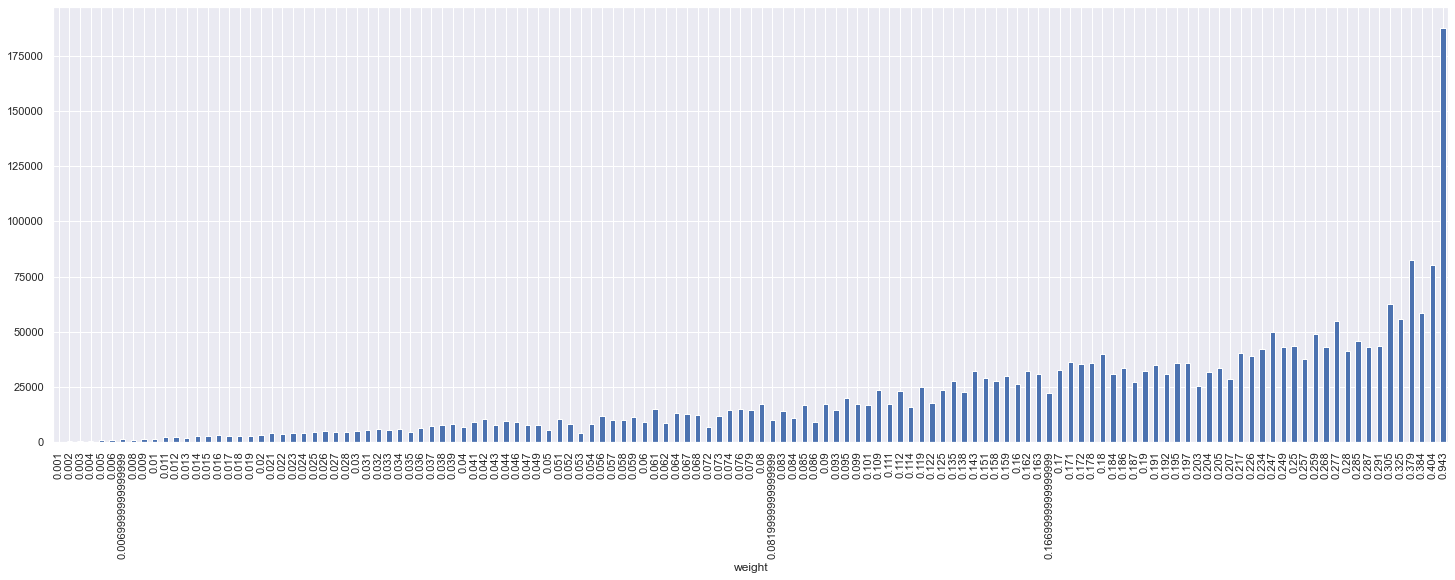

In [28]:
# 统计出不同weight下，qty库存使用量的均值
trainalldate.groupby('weight')['qty'].mean().plot.bar()

In [29]:
trainalldate.groupby('weight')['qty'].get_group(0.943)

279400              NaN
279401              NaN
279402              NaN
279403              NaN
279404              NaN
              ...      
280495    189514.666667
280496    189519.333333
280497    189548.666667
280498    189543.666667
280499    189610.333333
Name: qty, Length: 1100, dtype: float64

## 2.3 geography和product与库存销量qty之间的关系


In [21]:
# weight num and unit
trainalldate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int32         
 2   qty                346768 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   week               695200 non-null  int64         
 7   geography_level_1  695200 non-null  int32         
 8   geography_level_2  695200 non-null  int32         
 9   geography_level_3  695200 non-null  int32         
 10  product_level_1    695200 non-null  int32         
 11  product_level_2    695200 non-null  int32         
 12  unit_geo           695200 non-null  int32         
 13  unit_pro           695200 non-null  int32   

<AxesSubplot:xlabel='geography_level_3'>

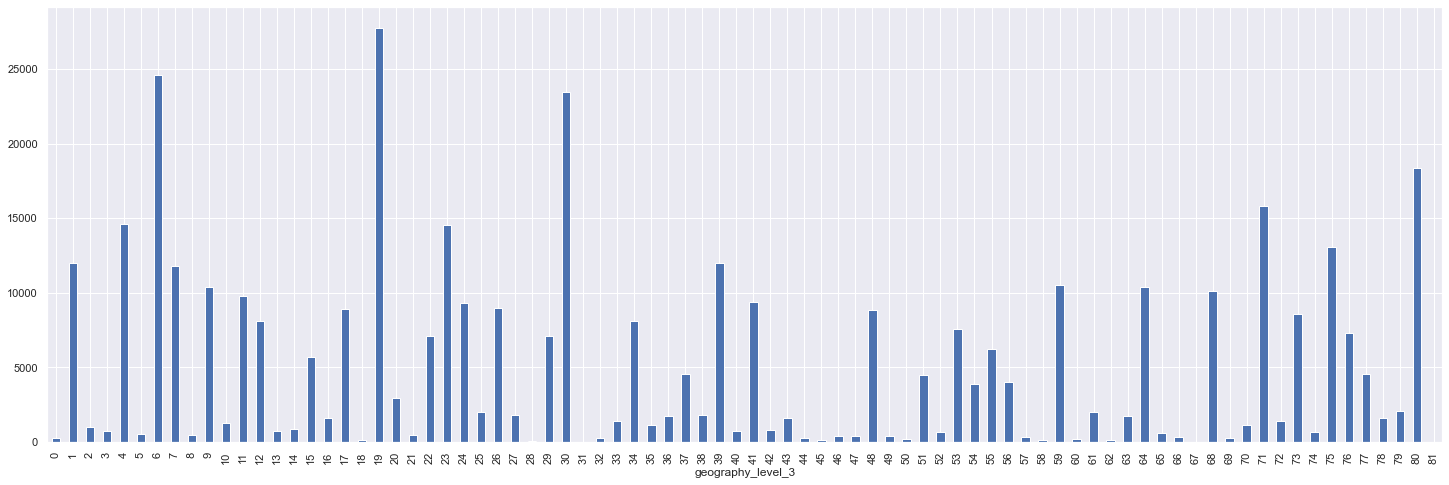

In [25]:
# 统计出不同weight下，qty库存使用量的均值
trainalldate.groupby('geography_level_3')['qty'].mean().plot.bar()

In [32]:
dict(trainalldate.groupby('geography_level_3')['unit'].count())

{0: 1581,
 1: 6984,
 2: 3214,
 3: 3466,
 4: 10099,
 5: 1834,
 6: 4494,
 7: 6605,
 8: 3335,
 9: 9787,
 10: 3138,
 11: 7340,
 12: 4455,
 13: 676,
 14: 3321,
 15: 3710,
 16: 3919,
 17: 1965,
 18: 745,
 19: 956,
 20: 3405,
 21: 1373,
 22: 3880,
 23: 6082,
 24: 9795,
 25: 6152,
 26: 5826,
 27: 6771,
 28: 280,
 29: 3565,
 30: 6738,
 31: 714,
 32: 3896,
 33: 6871,
 34: 5488,
 35: 4179,
 36: 5689,
 37: 5628,
 38: 4652,
 39: 8497,
 40: 1610,
 41: 6878,
 42: 1919,
 43: 2305,
 44: 1542,
 45: 1097,
 46: 2328,
 47: 3327,
 48: 2990,
 49: 4055,
 50: 3355,
 51: 2990,
 52: 3720,
 53: 8804,
 54: 5901,
 55: 2564,
 56: 4454,
 57: 3311,
 58: 781,
 59: 7370,
 60: 5724,
 61: 7050,
 62: 994,
 63: 1653,
 64: 4797,
 65: 3146,
 66: 1207,
 67: 425,
 68: 7181,
 69: 3765,
 70: 4475,
 71: 1940,
 72: 5123,
 73: 10202,
 74: 3532,
 75: 10364,
 76: 7319,
 77: 9323,
 78: 671,
 79: 1331,
 80: 4140,
 81: 348432}

<AxesSubplot:xlabel='product_level_2'>

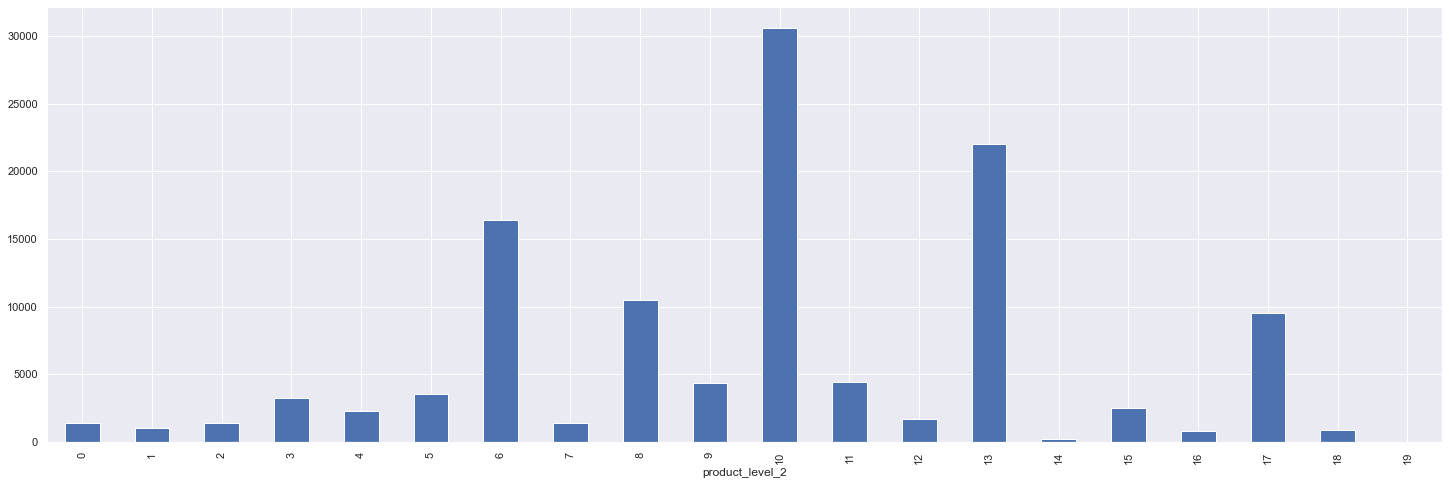

In [26]:
# 统计出不同weight下，qty库存使用量的均值
trainalldate.groupby('product_level_2')['qty'].mean().plot.bar()

# 3. 模型训练

- 1 Xgboost
- 2.LightGBM
- 3.autox
- 4.JDCross
- ref  
https://github.com/PENGZhaoqing/TimeSeriesPrediction  
https://github.com/gabrielpreda/Kaggle/blob/master/SantanderCustomerTransactionPrediction/starter-code-saving-and-loading-lgb-xgb-cb.py

## 3.1 Xgboost 

In [3]:
# load traindataset
with open("../output/traindataset.pkl", 'rb') as fo:     # 读取pkl文件数据
    traindataset = pickle.load(fo, encoding='bytes')

traindataset["ts"] = traindataset["ts"].apply(lambda x: pd.to_datetime(x))
print(traindataset.shape)
traindataset.head()

(695200, 48)


,ts,unit,qty,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,...,geo1mean14,geo2mean14,geo3mean14,pro1mean14,pro2mean14,geo1median14,geo2median14,geo3median14,pro1median14,pro2median14
0,2018-06-04,386,11926.8286,2018,6,4,0,5,12,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1100,2018-06-04,463,6282.7266,2018,6,4,0,0,3,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2200,2018-06-04,273,285.3290,2018,6,4,0,0,10,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3300,2018-06-04,520,6672.6452,2018,6,4,0,1,11,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4400,2018-06-04,480,15204.5902,2018,6,4,0,7,4,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
traindataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695200 entries, 0 to 695199
Data columns (total 48 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ts                 695200 non-null  datetime64[ns]
 1   unit               695200 non-null  int64         
 2   qty                345316 non-null  float64       
 3   year               695200 non-null  int64         
 4   month              695200 non-null  int64         
 5   day                695200 non-null  int64         
 6   week               695200 non-null  int64         
 7   geography_level_1  695200 non-null  int64         
 8   geography_level_2  695200 non-null  int64         
 9   geography_level_3  695200 non-null  int64         
 10  product_level_1    695200 non-null  int64         
 11  product_level_2    695200 non-null  int64         
 12  unit_pro           695200 non-null  int64         
 13  geo_pro            695200 non-null  int64   

In [5]:
# features
sparse_features = ['unit', 'year', 'month', 'day', 'week', 'geography_level_1', 'geography_level_2', 'geography_level_3', 
                   'product_level_1', 'product_level_2', 'unit_pro', 'geo_pro']
dense_features = ['weight',
       'last14max', 'last14min', 'last14std', 'last14mean', 'last14median',
       'last14sum', 'last7max', 'last7min', 'last7std', 'last7mean',
       'last7median', 'last7sum', 'last3max', 'last3min', 'last3std',
       'last3mean', 'last3median', 'last3sum', 'last3value', 'last1value', 'last2mean',
       'last2sum', 'last2value', 'geo1mean14', 'geo2mean14', 'geo3mean14', 'pro1mean14',
       'pro2mean14', 'geo1median14', 'geo2median14', 'geo3median14',
       'pro1median14', 'pro2median14']

target = ['qty']

In [6]:
# traindataset[:100].loc[~traindataset[:100]['geo1mean14'].isnull()]
# traindataset[np.isnan(traindataset['qty'].values)]
# traindataset['qty'][np.isinf(traindataset['qty'])] = 0.0 

# 替换空值，和选择大于0的数据
traindataset = traindataset.dropna(subset=["qty"])
traindataset = traindataset[traindataset["qty"] >= 0]
traindataset.shape

(345316, 48)

In [7]:
print(np.isnan(traindataset['qty']).any())
print(np.isinf(traindataset['qty']).any())

False
False


<Figure size 1296x720 with 0 Axes>

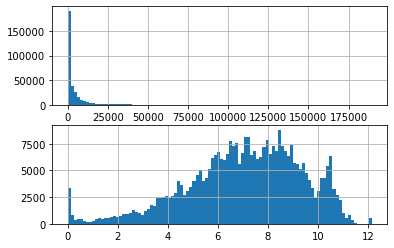

In [8]:
# qty 进行转化
plt.figure(figsize=(18, 10))
fig, axes = plt.subplots(nrows=2, ncols=1)
traindataset['qty'].hist(bins=100, ax=axes[0])
traindataset['qty'] = np.log(traindataset['qty'] + 1)  # 
traindataset['qty'].hist(bins=100, ax=axes[1])
plt.show()

In [9]:
## 3.1 xgboost
traindataset = traindataset.dropna(axis=0, how='any')
train = traindataset[traindataset.ts <= pd.to_datetime("20210301")]
test = traindataset[traindataset.ts > pd.to_datetime("20210301")]

X_train, X_test, y_train, y_test = train[sparse_features + dense_features], test[sparse_features + dense_features], train[target], test[target]
print('The shape of X_train:{}'.format(X_train.shape))
print('The shape of X_test:{}'.format(X_test.shape))

The shape of X_train:(281489, 46)
The shape of X_test:(61936, 46)


In [12]:
train.to_csv('../output/train.csv', index=False)
test.to_csv('../output/test.csv', index=False)

In [103]:
# ## 3.1 xgboost
# from sklearn.model_selection import train_test_split


# traindataset = traindataset.dropna(axis=0, how='any')
# X_train, X_test, y_train, y_test = train_test_split(traindataset[sparse_features + dense_features], traindataset[target], test_size=0.20)

# print('The shape of X_train:{}'.format(X_train.shape))
# print('The shape of X_test:{}'.format(X_test.shape))

The shape of X_train:(274740, 46)
The shape of X_test:(68685, 46)


In [134]:
params = {
    'learning_rate': 0.25,
    'n_estimators': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 12,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'gamma': 0
}

# dtrain = xgb.DMatrix(X, label=y, feature_names=x)

bst = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'], random_state=0,
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])
bst.fit(X_train.values, y_train.values)

[15:50:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=-1,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [135]:
pre = bst.predict(X_test.values)

# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)

mae: 0.0169853220505046
mae: 56.53049660927482
rmse: 232.05474656993192


In [31]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)


mae: 0.017451066539189278
mae: 53.12144455181579
rmse: 166.15749286109192


In [136]:
i = 1000
booster = bst.get_booster()
dtrain = xgb.DMatrix(np.array([X_train.iloc[i, :].values]))
print('Predicted probability: ' + str(booster.predict(dtrain)))
print('Predicted raw value: {}\n'.format(
    booster.predict(dtrain, output_margin=True)))
contribs = booster.predict(dtrain, pred_contribs=True)
contributions2 = zip(sparse_features + dense_features + ['Bias'], contribs[0])
print('Contributions (sorted by absolute value):\n' + '\n'.join(str(x)
                                                                for x in sorted(contributions2, key=lambda x: abs(x[1]), reverse=True)))
print("Sum of contributions {}".format(
    booster.predict(dtrain, pred_contribs=True).sum()))

Predicted probability: [8.244254]
Predicted raw value: [8.244254]

Contributions (sorted by absolute value):
('Bias', 7.0546613)
('last2mean', 0.7719071)
('last1value', 0.3835022)
('last3mean', 0.17534204)
('last2sum', 0.06704445)
('last3median', -0.064415015)
('last14max', -0.03296701)
('last2value', -0.03294077)
('weight', 0.018288495)
('last3min', -0.015065764)
('last14std', -0.013607538)
('last14min', -0.012635188)
('last7min', -0.012374556)
('last7mean', -0.01132545)
('last7max', 0.010692167)
('last7median', -0.010589252)
('last14sum', -0.008275344)
('last3sum', -0.007773809)
('last14mean', -0.007369822)
('last3max', 0.005856699)
('last3value', -0.0050788736)
('day', -0.004551134)
('pro2mean14', 0.0030447177)
('last7std', -0.002589934)
('last14median', -0.002218429)
('last3std', -0.0021336535)
('geography_level_1', -0.0014696874)
('last7sum', -0.0013770126)
('week', 0.001257011)
('unit', -0.0011221771)
('geo3mean14', 0.0010528992)
('year', -0.0009949913)
('geography_level_3', 0.00

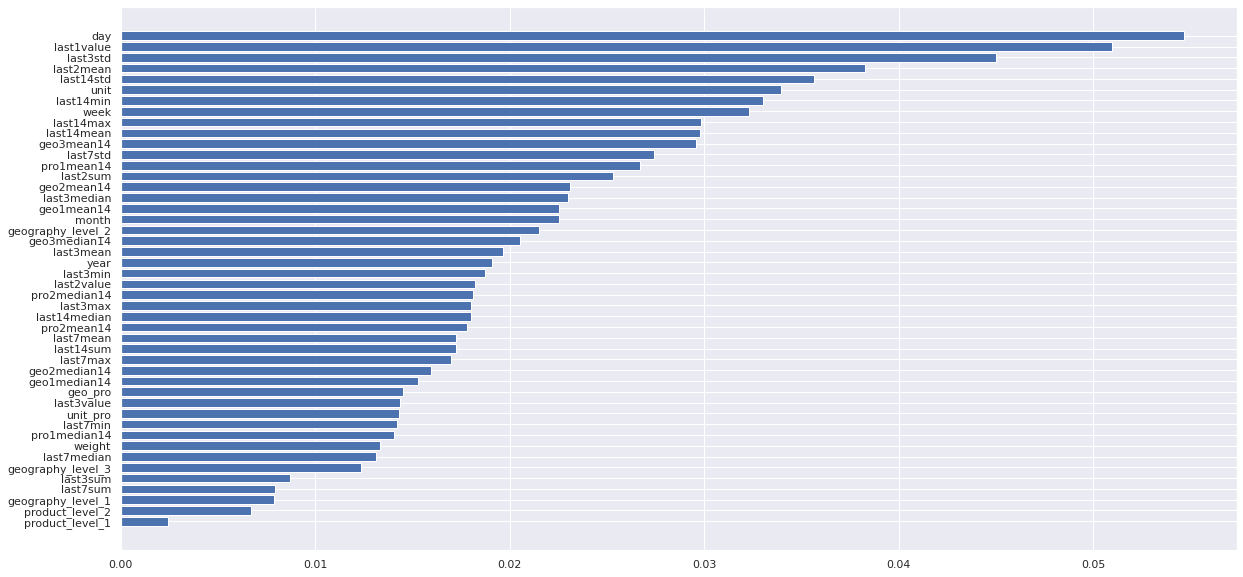

In [137]:
def get_xgb_feat_importances(clf, train_features):

    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.get_booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()
    
    feat_importances = []
    
    for feat, value in zip(fscore.keys(), train_features):
        feat_importances.append({'Feature': value, 'Importance': fscore[feat]})
    
    # for ft, score in fscore.items():
    #     feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    # Print the most important features and their importances
    return dict(zip(fscore.keys(), train_features)), feat_importances


f, res = get_xgb_feat_importances(bst, sparse_features + dense_features)

plt.figure(figsize=(20, 10))
plt.barh(range(len(res)), res['Importance'][::-1], tick_label=res['Feature'][::-1])
plt.show()

In [138]:
f

{'f0': 'unit',
 'f1': 'year',
 'f2': 'month',
 'f3': 'day',
 'f4': 'week',
 'f5': 'geography_level_1',
 'f6': 'geography_level_2',
 'f7': 'geography_level_3',
 'f8': 'product_level_1',
 'f9': 'product_level_2',
 'f10': 'unit_pro',
 'f11': 'geo_pro',
 'f12': 'weight',
 'f13': 'last14max',
 'f14': 'last14min',
 'f15': 'last14std',
 'f16': 'last14mean',
 'f17': 'last14median',
 'f18': 'last14sum',
 'f19': 'last7max',
 'f20': 'last7min',
 'f21': 'last7std',
 'f22': 'last7mean',
 'f23': 'last7median',
 'f24': 'last7sum',
 'f25': 'last3max',
 'f26': 'last3min',
 'f27': 'last3std',
 'f28': 'last3mean',
 'f29': 'last3median',
 'f30': 'last3sum',
 'f31': 'last3value',
 'f32': 'last1value',
 'f33': 'last2mean',
 'f34': 'last2sum',
 'f35': 'last2value',
 'f36': 'geo1mean14',
 'f37': 'geo2mean14',
 'f38': 'geo3mean14',
 'f39': 'pro1mean14',
 'f40': 'pro2mean14',
 'f41': 'geo1median14',
 'f42': 'geo2median14',
 'f43': 'geo3median14',
 'f44': 'pro1median14',
 'f45': 'pro2median14'}

<Figure size 1440x720 with 0 Axes>

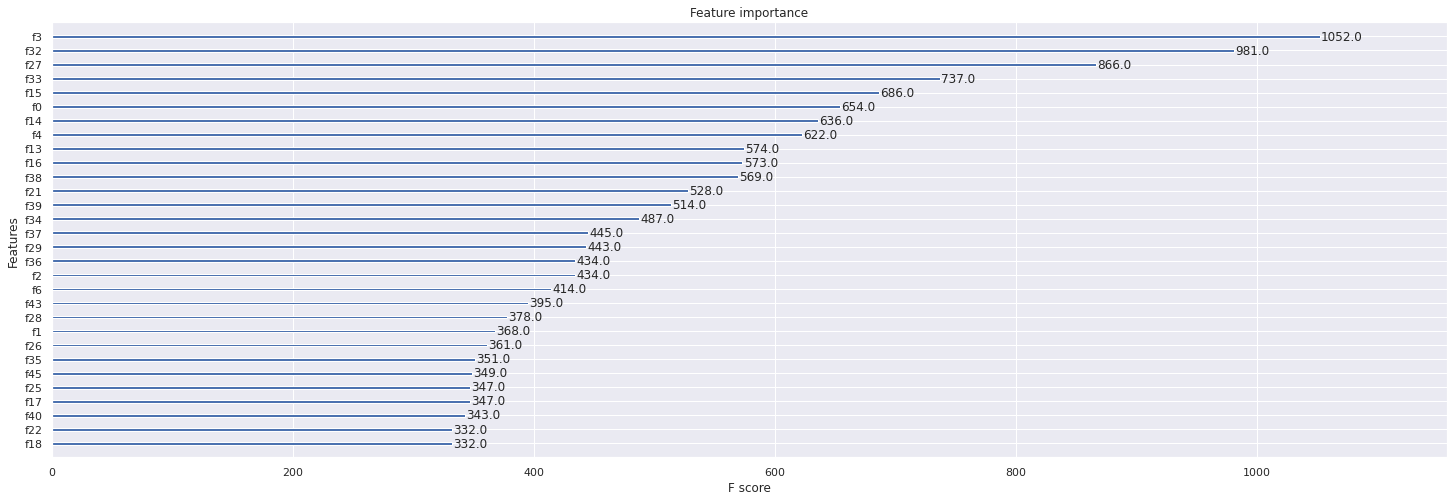

In [139]:
from xgboost import plot_importance

plt.figure(figsize=(20,10))
plot_importance(bst, max_num_features=30)
plt.show()

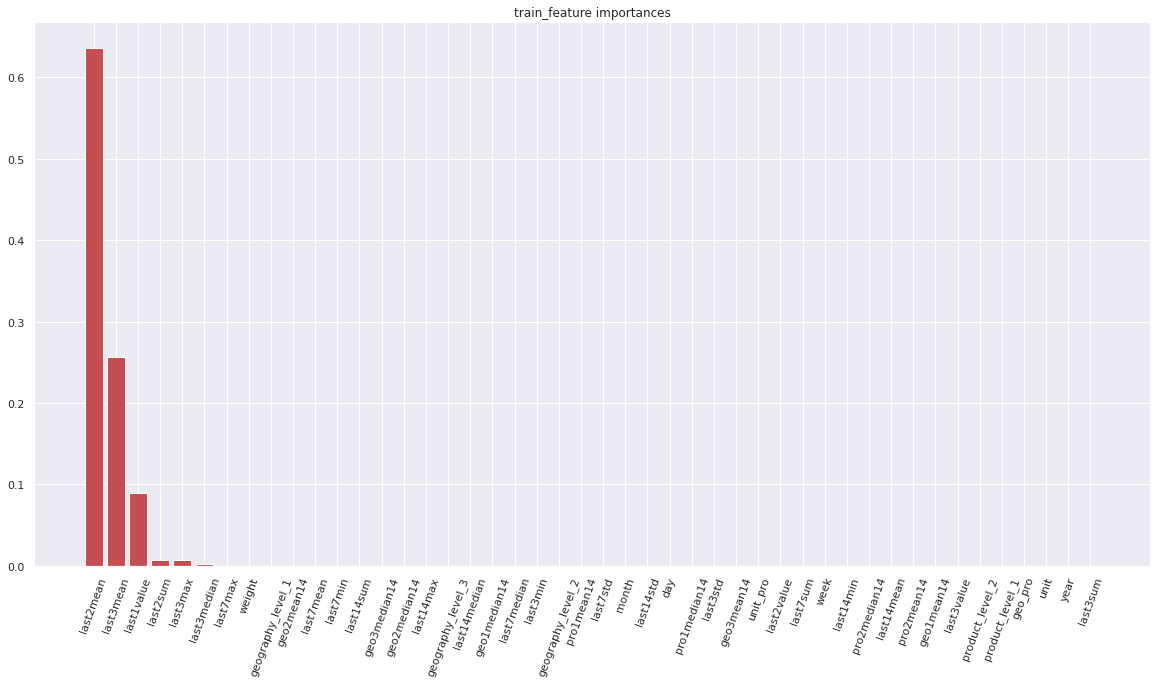

In [140]:

def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],
            color="r", align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()
    

    
feature_vis(bst,  sparse_features + dense_features)


In [141]:
# plot the model result

data = X_test.copy()
data['qty'] = np.expm1(y_test)
data['pre_qty'] = np.expm1(pre)

In [142]:
data.head()

,unit,year,month,day,week,geography_level_1,geography_level_2,geography_level_3,product_level_1,product_level_2,...,geo3mean14,pro1mean14,pro2mean14,geo1median14,geo2median14,geo3median14,pro1median14,pro2median14,qty,pre_qty
1002,386,2021,3,2,1,5,12,11,1,6,...,7709.537254,20193.916072,19104.613245,705.998806,1539.003635,5733.833333,16845.4902,16623.2496,15624.4286,15485.251953
2102,463,2021,3,2,1,0,3,75,1,6,...,13567.202840,20193.916072,19104.613245,2784.529622,4174.833333,4980.000000,16845.4902,16623.2496,40947.1266,40688.589844
3202,273,2021,3,2,1,0,10,7,1,6,...,11241.741821,20193.916072,19104.613245,2784.529622,3385.894911,7220.000000,16845.4902,16623.2496,1820.5290,1813.172241
4302,520,2021,3,2,1,1,11,23,1,6,...,14139.311932,20193.916072,19104.613245,2154.072808,2187.187500,2961.583333,16845.4902,16623.2496,36673.2452,36644.664062
5402,480,2021,3,2,1,7,4,76,1,6,...,7275.798457,20193.916072,19104.613245,1246.500000,1246.500000,3289.083333,16845.4902,16623.2496,16863.3902,16996.164062


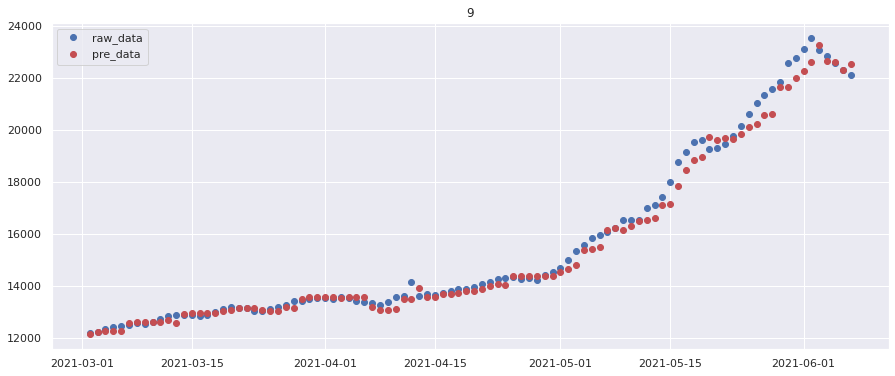

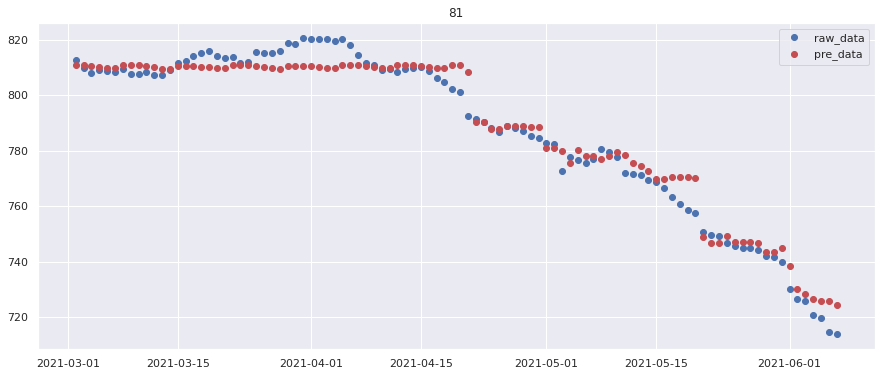

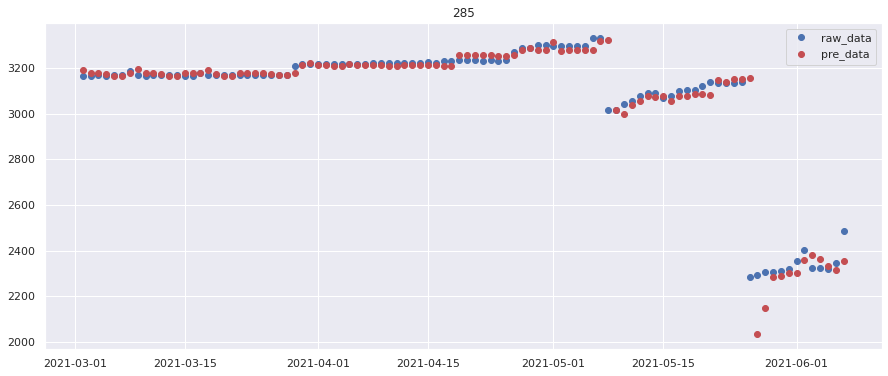

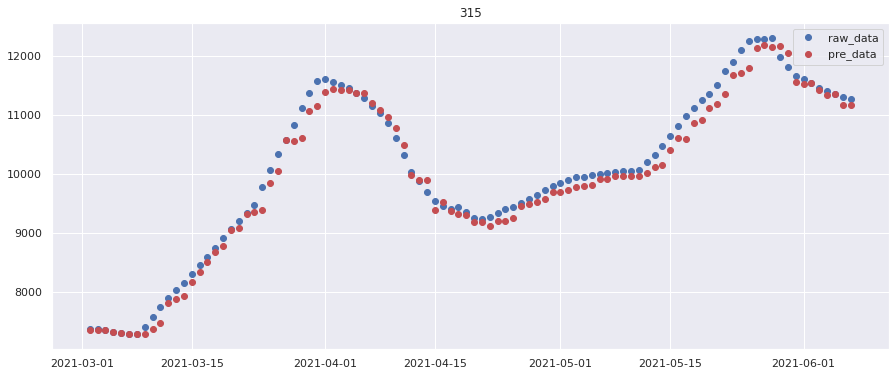

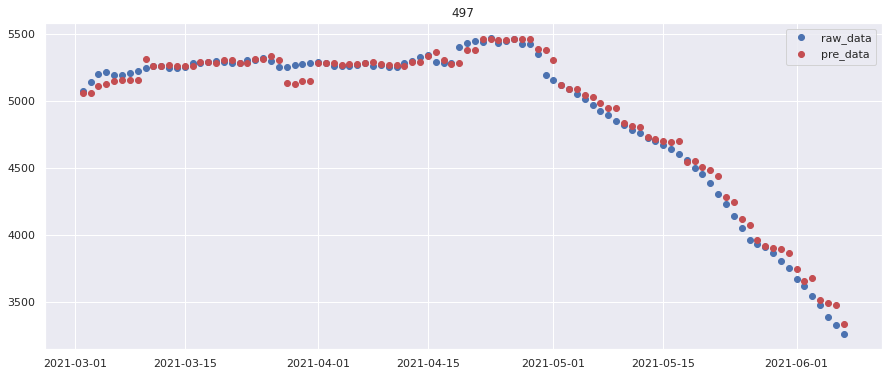

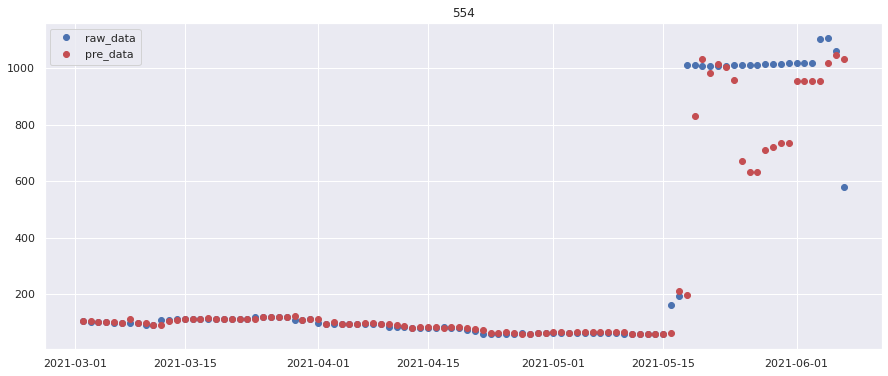

""


In [143]:
def date_trend(data):
    val = data.sort_values(
        by=['year', 'month', 'day'], ascending=True).reset_index(drop=True)
    
    val["date"] = val.apply(lambda x: f"{int(x['year'])}-{int(x['month'])}-{int(x['day'])}", axis=1)
    val["date"] = val["date"].apply(lambda x: pd.to_datetime(x))

    if val.unit.values[0] in [497, 81, 9, 285, 554, 315]:
        plt.figure(figsize=(15, 6))
        l1 = plt.plot(val.date, val['qty'], 'o', label='raw_data')
        l2 = plt.plot(val.date, val['pre_qty'], 'ro', label="pre_data")
        plt.legend()
        # plt.plot(val.date, val['qty'], 'o', val.date, val['pre_qty'], 'ro')
        plt.title(str(val.unit.values[0]))
        plt.show()
    


data.groupby('unit').apply(date_trend)

In [144]:
val = data.groupby('unit').get_group(497).sort_values(
        by=['year', 'month', 'day'], ascending=True).reset_index(drop=True)

In [145]:
val["date"] = val.apply(lambda x: f"{int(x['year'])}-{int(x['month'])}-{int(x['day'])}", axis=1)

In [146]:
val["date"] = val["date"].apply(lambda x: pd.to_datetime(x))

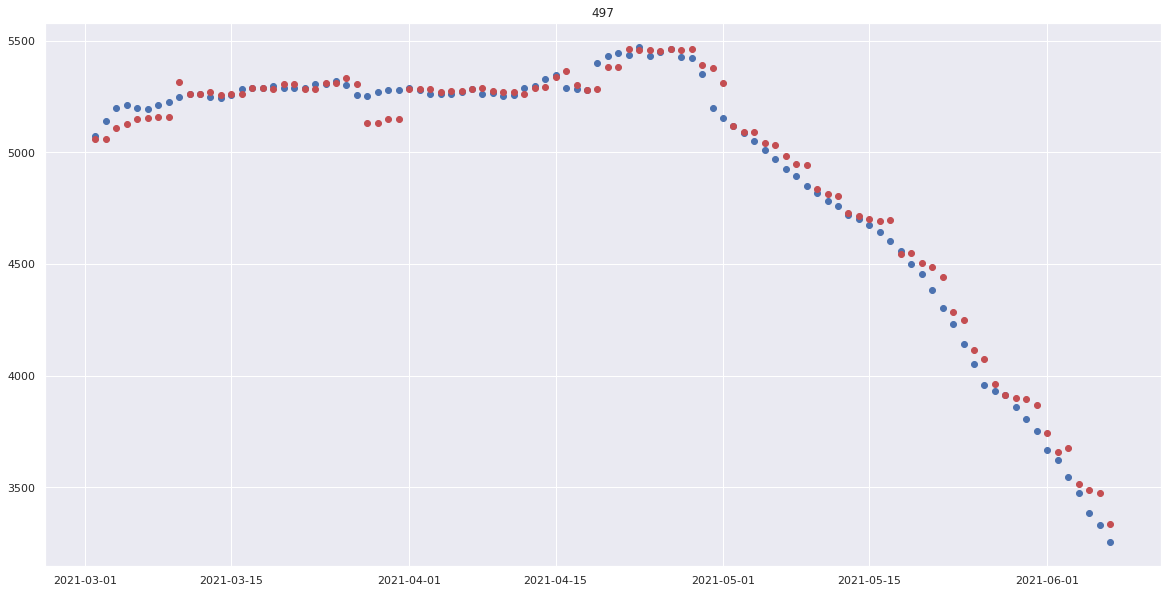

In [147]:

plt.figure(figsize=(20, 10))
plt.plot(val.date, val['qty'], 'o', val.date, val['pre_qty'], 'ro')
plt.title("497")
plt.show()

## 3.2 LightGBM

In [34]:
import lightgbm as lgb
from lightgbm import plot_importance

In [36]:

# 构造训练集
dtrain = lgb.Dataset(X_train,y_train)
dtest = lgb.Dataset(X_test,y_test)

print(dtrain)

In [38]:
params = {
    'booster': 'gbtree',
    'objective': 'regression',
    'num_leaves': 31,
    'subsample': 0.8,
    'bagging_freq': 1,
    'feature_fraction ': 0.8,
    'slient': 1,
    'learning_rate ': 0.1,
    'seed': 0
}

num_rounds = 500

# xgboost模型训练
lgbmodel = lgb.train(params,dtrain, num_rounds, valid_sets=[dtrain, dtest], 
                  verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.402619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8981
[LightGBM] [Info] Number of data points in the train set: 275311, number of used features: 44
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] Unknown parameter: 0.8
[LightGBM] [Warning] Unknown parameter: slient
[LightGBM] [Info] Start training from score 7.062420
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00480988	valid_1'

In [39]:
# 对测试集进行预测
pre_lgb = lgbmodel.predict(X_test)

In [40]:
# def mape(y_true, y_pred):
#     return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

# mape = mape(np.expm1(y_test.reshape(-1)), np.expm1(pre))
# print("MAPE is: {}".format(mape))

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_norm = mean_absolute_error(y_test.values, pre_lgb)  # 归一化后的值
mae = mean_absolute_error(np.expm1(y_test.values), np.expm1(pre_lgb))


rmse = np.sqrt(mean_squared_error(np.expm1(y_test.values), np.expm1(pre_lgb)))

print("mae:",mae_norm)
print("mae:",mae)
print("rmse:",rmse)


mae: 0.018923955297323495
mae: 81.15812502488455
rmse: 307.6095513832293


<Figure size 1440x720 with 0 Axes>

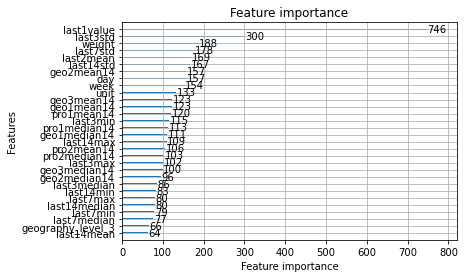

In [46]:
# 显示重要特征
plt.figure(figsize=(20,10))
plot_importance(lgbmodel, max_num_features=30)
plt.show()

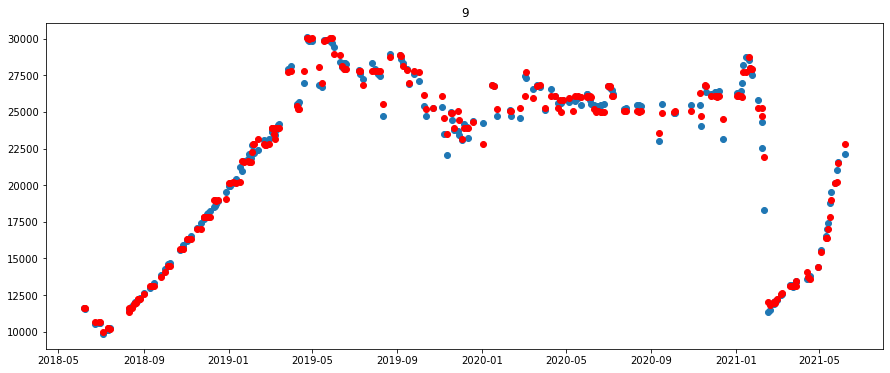

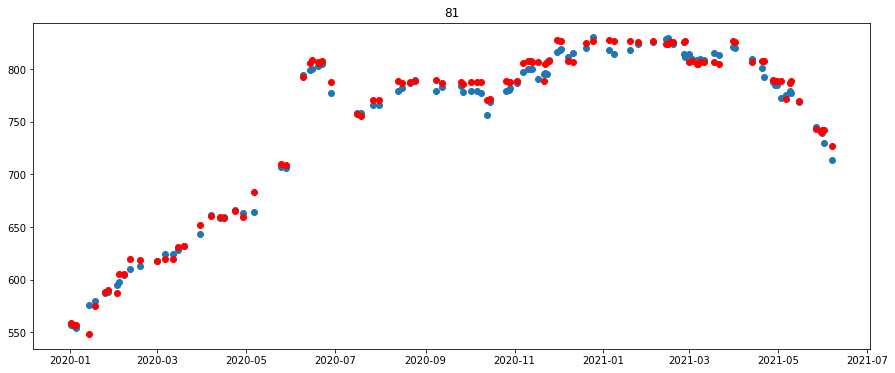

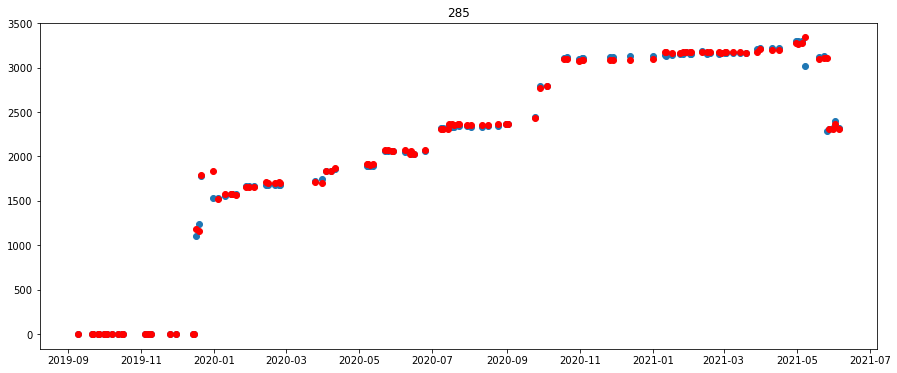

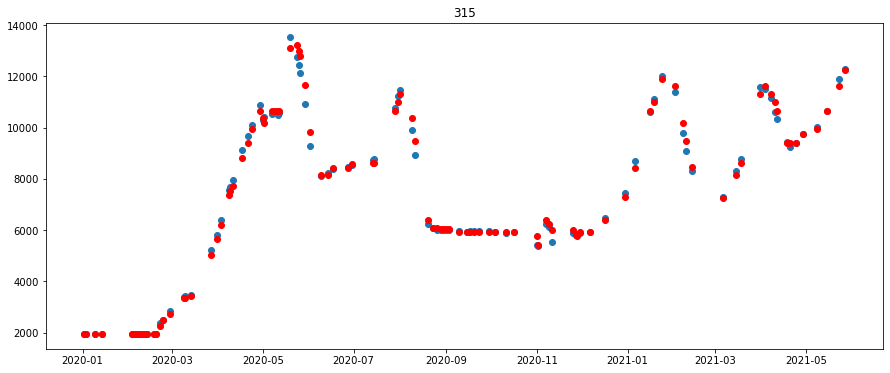

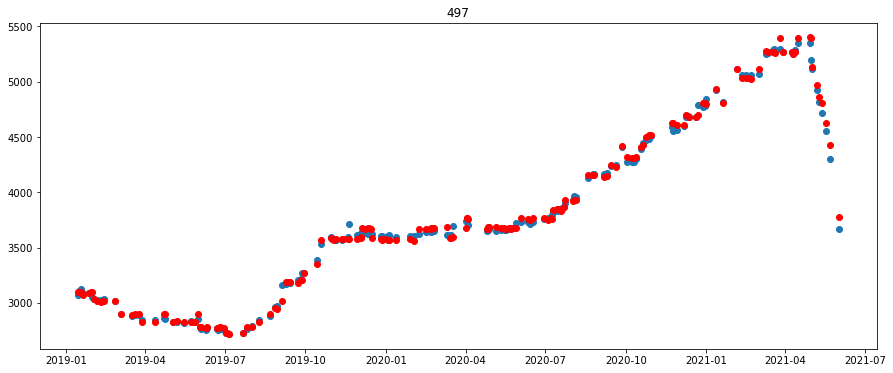

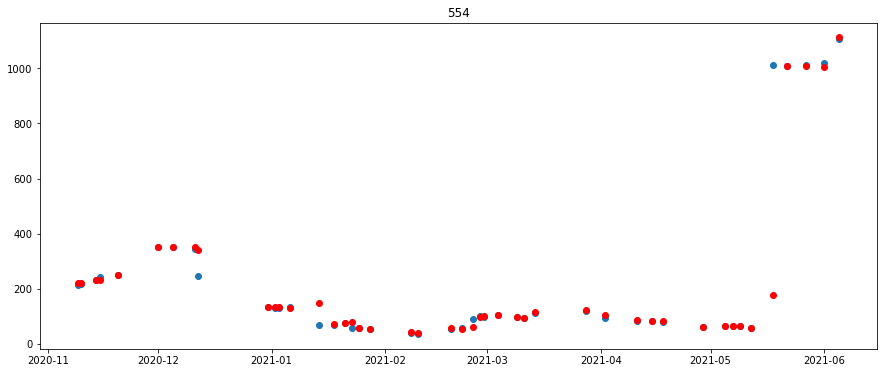

""


In [48]:
# plot the model result

data = X_test.copy()
data['qty'] = np.expm1(y_test)
data['pre_qty'] = np.expm1(pre_lgb)

data.groupby('unit').apply(date_trend)

In [52]:
prev = data[['qty', 'pre_qty']].copy()
prev['xgb_pre_qty'] = np.expm1(pre)
prev

,qty,pre_qty,xgb_pre_qty
328733,17350.229492,17050.775870,17381.859375
571375,1318.336046,1315.011795,1337.043335
504732,53285.144800,54809.753678,53362.332031
572271,391.000000,395.998578,389.578491
100498,8023.032800,7925.544866,7982.210938
...,...,...,...
595222,362.666667,360.837127,361.036011
548035,7899.236654,7878.007697,7897.741211
371998,9151.666667,9143.002585,9188.644531
517264,385.833333,389.723144,387.882538


## 3.3 autox


In [ ]:
# 使用了xgboost 和 lightgbm两者之间进行了融合

# 模型预测
predict_lgb = model_lgb.predict(test, used_features)
predict_xgb = model_xgb.predict(test, used_features)
# predict_cat = model_cat.predict(test, used_features)
# predict_tabnet = model_tabnet.predict(test[used_features])
# predict = (predict_xgb + predict_lgb + predict_cat) / 3
predict = (predict_xgb * 0.5 + predict_lgb * 0.5)



## 3.4 ARIMA

- 1 使用ARIMA 训练样本 train [2018/6/4 - 2021/3/1]， 分成不同的unit, 分别预测 train [2018/6/4 - 2021/3/1] 的结果
- 2 由于有的unit会存在 在训练集中该时间段NaN，于是不考虑这些值。
- 3 用真是值 - 预测值，然后下游利用 xgboos等模型做回归。

In [ ]:
CREATE TABLE `units_resource_sales` (
  `unit` VARCHAR(32) DEFAULT NULL COMMENT '商品单元',
  `qty` DECIMAL(17,4) DEFAULT NULL COMMENT '商品资源使用量',
  `dt` DATE NOT NULL,
  KEY `unit` (`unit`)
) ENGINE=INNODB DEFAULT CHARSET=utf8mb4 COMMENT='商品资源使用表'
hive